# XGBoost Multi-Output Regression with Nested CV
This notebook trains a global XGBoost model to predict **HI, TMAX, RH** using multi-output regression with **nested cross-validation**, chronological splits, and early stopping.

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import xgboost as xgb

# Ensure output folders
os.makedirs("models", exist_ok=True)


In [6]:
# Load all station CSVs from merged_datasets folder
folder = "merged_datasets"
all_data = []

for file in os.listdir(folder):
    if file.endswith(".csv"):
        station = file.replace(".csv", "")
        df = pd.read_csv(os.path.join(folder, file))
        df["STATION"] = station
        all_data.append(df)

data = pd.concat(all_data, ignore_index=True)

print("Shape:", data.shape)
data.head()


Shape: (87648, 21)


,YEAR,MONTH,DAY,TMAX,TMIN,RH,WIND_SPEED,WIND_DIRECTION,HI,Albedo_linear,...,skin_temperature_min_C,skin_temperature_max_C,NDBaI_linear,NDBaI_spline,NDBI_linear,NDBI_spline,NDVI_original,NDWI_linear,NDWI_spline,STATION
0,2014,1,1.0,30.4,22.8,74.0,2.0,40.0,34.3,0.334435,...,22.823269,28.944388,0.131949,0.197894,-0.131949,-0.199351,0.664753,-0.336428,-0.333871,Ambulong Daily Data
1,2014,1,2.0,29.9,20.0,74.0,2.0,40.0,33.3,0.334435,...,20.933704,29.484714,0.131949,0.198007,-0.131949,-0.199470,0.444930,-0.336428,-0.333871,Ambulong Daily Data
2,2014,1,3.0,31.0,20.5,79.0,1.0,40.0,35.9,0.334435,...,20.474327,30.888305,0.131949,0.198119,-0.131949,-0.199588,0.567675,-0.336428,-0.333871,Ambulong Daily Data
3,2014,1,4.0,32.0,22.5,76.0,1.0,40.0,38.0,0.334435,...,21.502426,31.348300,0.131949,0.198232,-0.131949,-0.199705,0.628662,-0.336428,-0.333871,Ambulong Daily Data
4,2014,1,5.0,30.6,23.0,75.0,2.0,40.0,34.7,0.334435,...,22.769479,29.305708,0.131949,0.198344,-0.131949,-0.199823,0.528463,-0.336428,-0.333871,Ambulong Daily Data


In [7]:
# Seasonal helper
def get_philippines_season(month):
    # 0 = dry, 1 = wet (simplified)
    return 0 if month in [1,2,3,4,11,12] else 1

data['DATE'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY']], errors='coerce')

# Add engineered features
data['DAY_OF_YEAR'] = data['DATE'].dt.dayofyear
data['SEASON'] = data['MONTH'].apply(get_philippines_season)
data['IS_DRY_SEASON'] = (data['SEASON'] == 0).astype(int)
data['IS_WET_SEASON'] = (data['SEASON'] == 1).astype(int)
data['IS_SOUTHWEST_MONSOON'] = data['MONTH'].apply(lambda x: 1 if x in [6,7,8,9] else 0)
data['IS_NORTHEAST_MONSOON'] = data['MONTH'].apply(lambda x: 1 if x in [12,1,2,3] else 0)

if 'TMAX' in data.columns and 'TMIN' in data.columns:
    data['TEMP_RANGE'] = data['TMAX'] - data['TMIN']
    data['TEMP_MEAN'] = (data['TMAX'] + data['TMIN']) / 2

if 'WIND_SPEED' in data.columns and 'WIND_DIRECTION' in data.columns:
    data['WIND_U'] = -data['WIND_SPEED'] * np.sin(np.radians(data['WIND_DIRECTION']))
    data['WIND_V'] = -data['WIND_SPEED'] * np.cos(np.radians(data['WIND_DIRECTION']))

if 'NDVI_original' in data.columns and 'NDBI_linear' in data.columns:
    data['URBAN_VEG_RATIO'] = data['NDBI_linear'] / (data['NDVI_original'] + 0.001)
    
data = data.sort_values(by=['DATE', 'STATION']).reset_index(drop=True)
data = data.dropna(subset=['DATE'])

station_col = "STATION"
hi_col = "HI"
data['HI_t+1'] = data.groupby(station_col)[hi_col].shift(-1)
data['HI_t+2'] = data.groupby(station_col)[hi_col].shift(-2)
    
target_cols = ["HI_t+1", "HI_t+2"] 

feature_cols = [c for c in data.columns if c not in target_cols + ["STATION", "YEAR", "MONTH", "DAY", "DATE"]]

data = data.dropna(subset=['HI_t+1', 'HI_t+2'])

X = data[feature_cols]
y = data[target_cols]
stations = data["STATION"]

print("Features (Current Day Observations):", feature_cols)
print("Targets (Forecast Horizons):", target_cols)

print("After preprocessing:", data.shape)

Features (Current Day Observations): ['TMAX', 'TMIN', 'RH', 'WIND_SPEED', 'WIND_DIRECTION', 'HI', 'Albedo_linear', 'Albedo_spline', 'skin_temperature_min_C', 'skin_temperature_max_C', 'NDBaI_linear', 'NDBaI_spline', 'NDBI_linear', 'NDBI_spline', 'NDVI_original', 'NDWI_linear', 'NDWI_spline', 'DAY_OF_YEAR', 'SEASON', 'IS_DRY_SEASON', 'IS_WET_SEASON', 'IS_SOUTHWEST_MONSOON', 'IS_NORTHEAST_MONSOON', 'TEMP_RANGE', 'TEMP_MEAN', 'WIND_U', 'WIND_V', 'URBAN_VEG_RATIO']
Targets (Forecast Horizons): ['HI_t+1', 'HI_t+2']
After preprocessing: (87252, 35)


In [8]:
# Chronological 80-10-10 split (Enhanced Logic)
data_split = data.copy()

# Calculate split dates based on 80% and 90% indices
n = len(data_split)
train_end_idx = int(n * 0.7)
val_end_idx = int(n * 0.8)

# Get the date at the split points
train_end_date = data_split['DATE'].iloc[train_end_idx]
val_end_date = data_split['DATE'].iloc[val_end_idx]

# Split the data based on dates
X_train = X[data_split['DATE'] < train_end_date]
y_train = y[data_split['DATE'] < train_end_date]

X_val = X[(data_split['DATE'] >= train_end_date) & (data_split['DATE'] < val_end_date)]
y_val = y[(data_split['DATE'] >= train_end_date) & (data_split['DATE'] < val_end_date)]
stations_val = stations[(data_split['DATE'] >= train_end_date) & (data_split['DATE'] < val_end_date)]

X_test = X[data_split['DATE'] >= val_end_date]
y_test = y[data_split['DATE'] >= val_end_date]
stations_test = stations[data_split['DATE'] >= val_end_date]

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print(f"Train ends on: {train_end_date.date()}")
print(f"Validation ends on: {val_end_date.date()}")

Train: (61061, 28) Val: (8739, 28) Test: (17452, 28)
Train ends on: 2020-12-24
Validation ends on: 2021-12-24


In [9]:
# Define base estimator
xgb_est = xgb.XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    tree_method="hist",
    random_state=42
)

multi_est = MultiOutputRegressor(xgb_est)

# Hyperparameter grid for RandomizedSearchCV
param_grid = {
    "estimator__n_estimators": [200, 500, 1000],
    "estimator__learning_rate": [0.01, 0.05, 0.1],
    "estimator__max_depth": [3, 5, 7],
    "estimator__subsample": [0.7, 0.8, 1.0],
    "estimator__colsample_bytree": [0.7, 0.8, 1.0]
}

# Inner CV
tscv = TimeSeriesSplit(n_splits=3)

search = RandomizedSearchCV(
    estimator=multi_est,
    param_distributions=param_grid,
    n_iter=10,
    scoring="neg_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'estimator__subsample': 0.7, 'estimator__n_estimators': 1000, 'estimator__max_depth': 7, 'estimator__learning_rate': 0.01, 'estimator__colsample_bytree': 0.7}


In [12]:
best_params = search.best_params_
best_params_effective = {k.replace("estimator__", ""): v for k,v in best_params.items()}

# Ensure eval_metric is defined in the estimator, although we will pass it in fit() too
best_est = xgb.XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    tree_method="hist",
    early_stopping_rounds=20,
    random_state=42,
    **best_params_effective
)

final_model = MultiOutputRegressor(best_est)

In [17]:
best_params_effective = {k.replace("estimator__", ""): v for k,v in best_params.items()}

best_est = xgb.XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse", # Metric defined only in the constructor
    tree_method="hist",
    random_state=42,
    early_stopping_rounds=20,
    **best_params_effective
)

final_model = MultiOutputRegressor(best_est)

# Prepare Evaluation Sets for Early Stopping
n_targets = y_train.shape[1]
eval_sets = [(X_val, y_val.iloc[:, i]) for i in range(n_targets)] 

# CORRECTED FIT CALL: eval_metric removed, early_stopping_rounds included
final_model.fit(
    X_train, y_train,
    eval_set=eval_sets,
    verbose=False
)

print("XGBoost Multi-Output Model Training Complete.")

XGBoost Multi-Output Model Training Complete.


In [23]:
def evaluate_predictions(y_true, y_pred, stations_subset, target_cols):
    """Calculates overall metrics (MAE, RMSE, R2) for multi-output forecasting."""
    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred)
    
    all_results = []
    
    for i, target in enumerate(target_cols):
        y_true_target = y_true_arr[:, i]
        y_pred_target = y_pred_arr[:, i]
        
        overall_mae = mean_absolute_error(y_true_target, y_pred_target)
        overall_rmse = np.sqrt(mean_squared_error(y_true_target, y_pred_target))
        overall_r2 = r2_score(y_true_target, y_pred_target)
        
        all_results.append({
            "Target": target, 
            "Station": "ALL_STATIONS_OVERALL", 
            "MAE": overall_mae, 
            "RMSE": overall_rmse, 
            "R2": overall_r2
        })
            
    return pd.DataFrame(all_results)


# Make predictions 
test_pred = final_model.predict(X_test)

# Evaluate and display
target_cols = ["HI_t+1", "HI_t+2"]
df_test_metrics = evaluate_predictions(y_test, test_pred, stations_test, target_cols)

print("\n=== Final Forecast Performance Metrics (Averaged all stations) ===")
display(df_test_metrics)


=== Final Forecast Performance Metrics (Averaged all stations) ===


,Target,Station,MAE,RMSE,R2
0,HI_t+1,ALL_STATIONS_OVERALL,1.868632,2.535551,0.790851
1,HI_t+2,ALL_STATIONS_OVERALL,2.162646,2.906264,0.725073


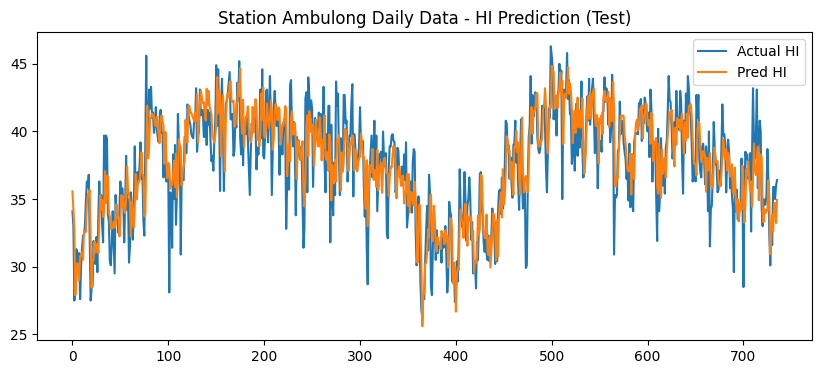

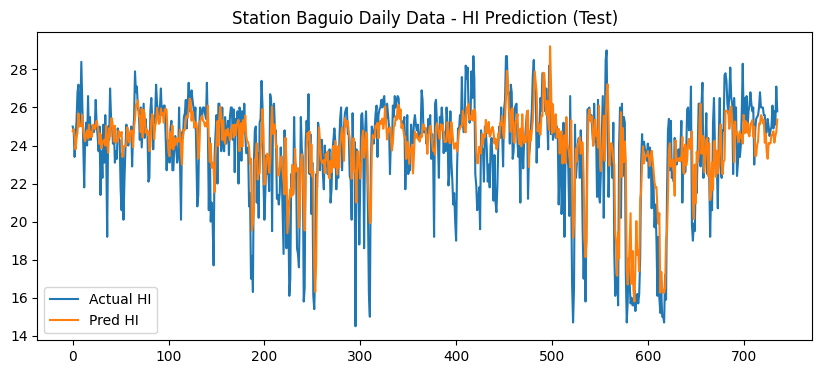

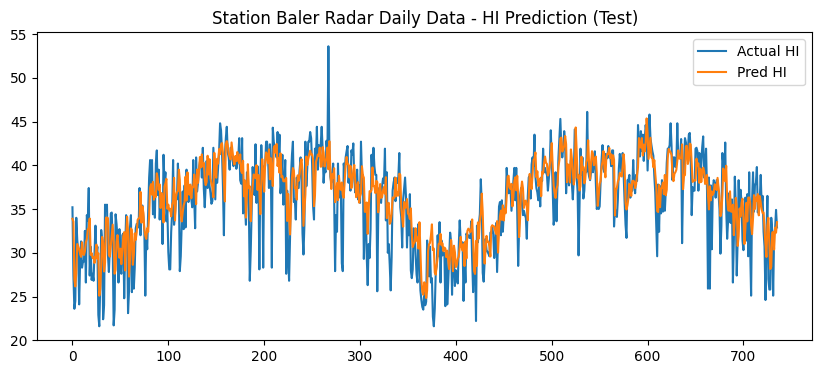

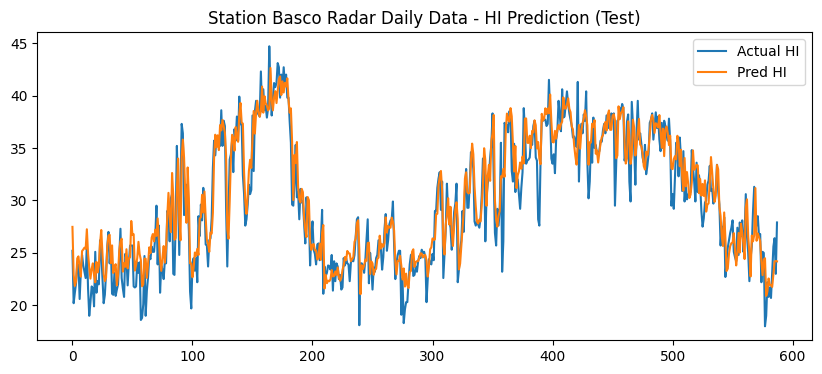

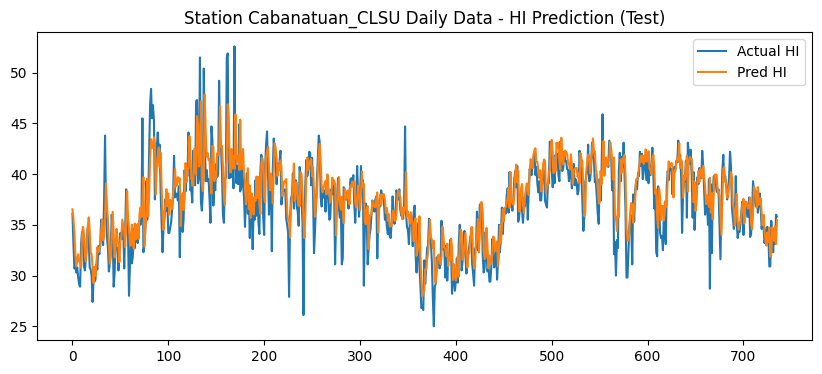

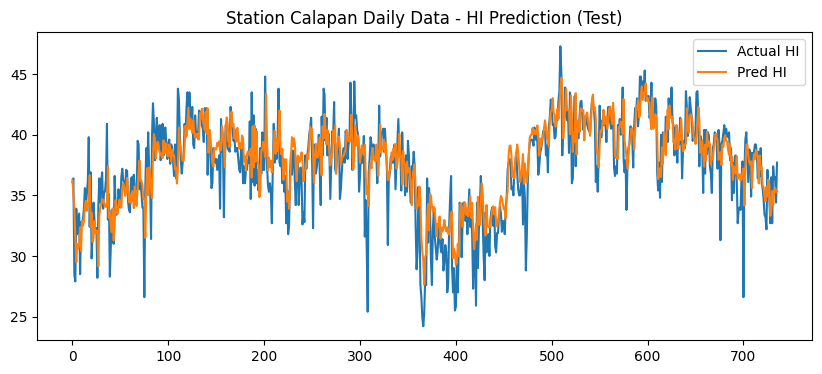

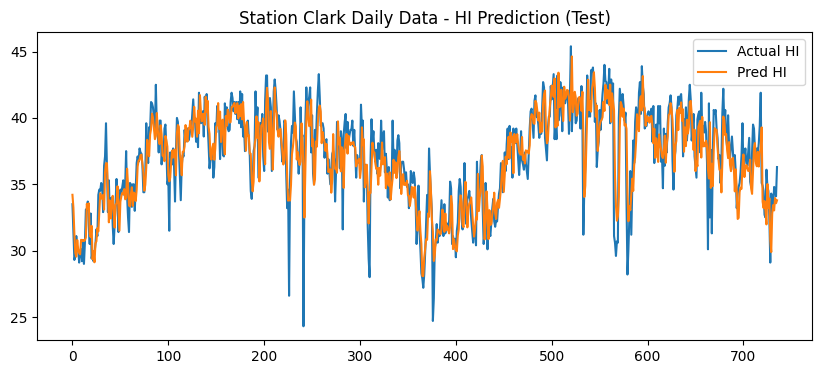

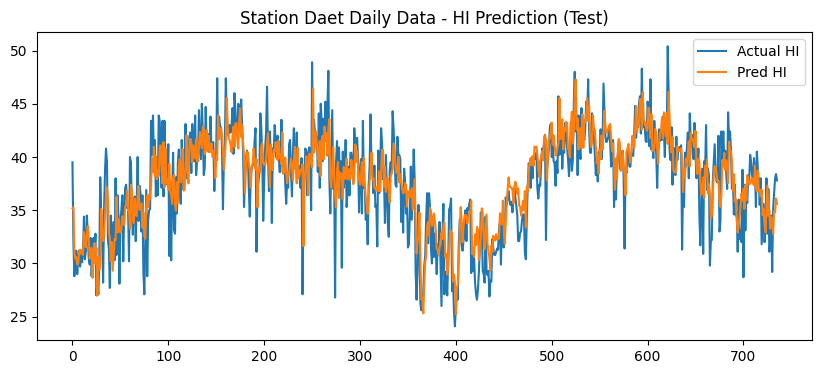

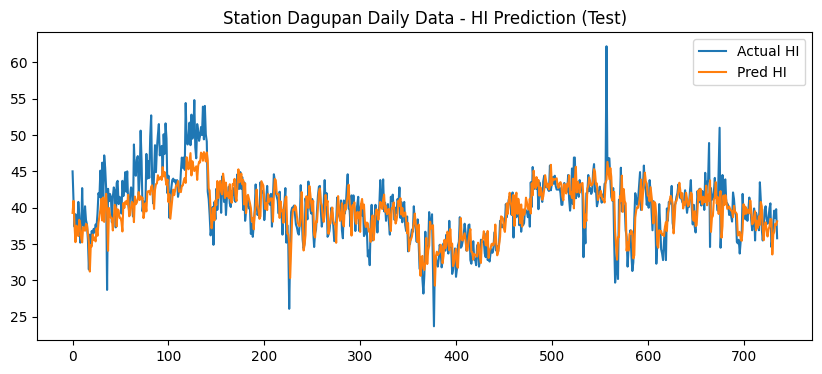

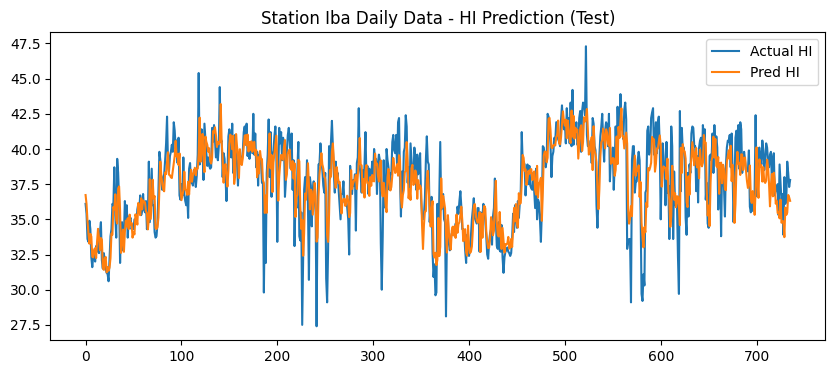

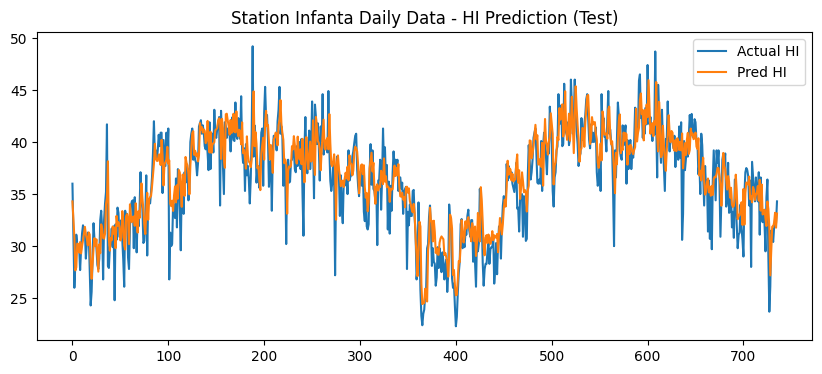

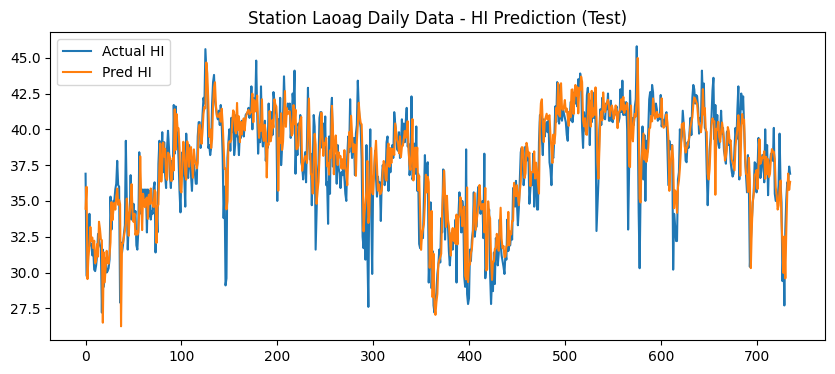

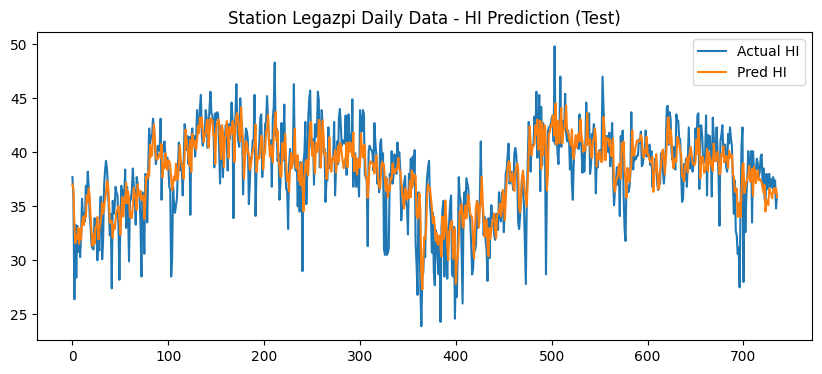

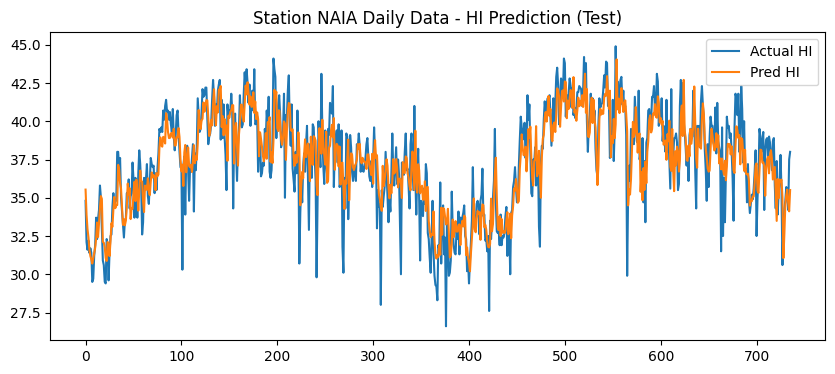

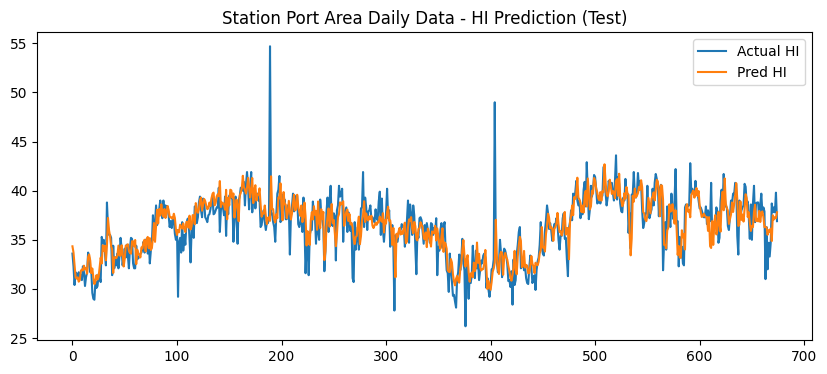

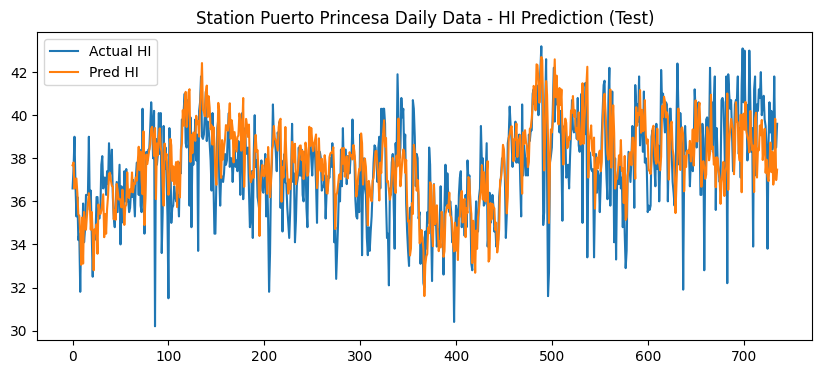

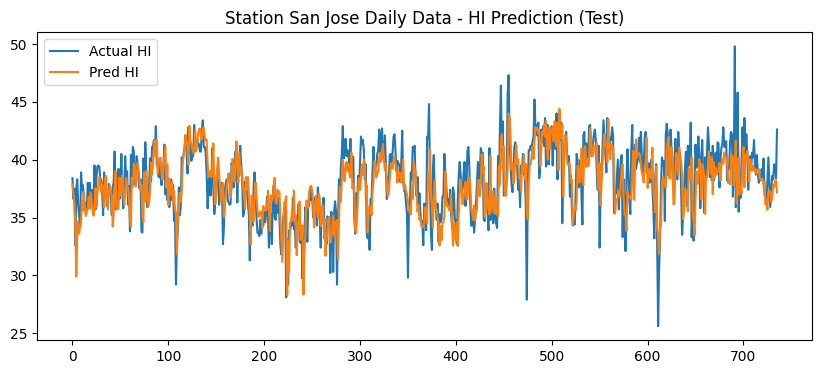

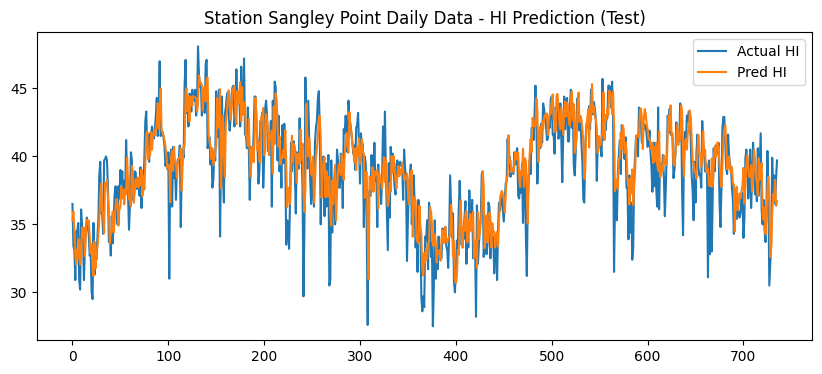

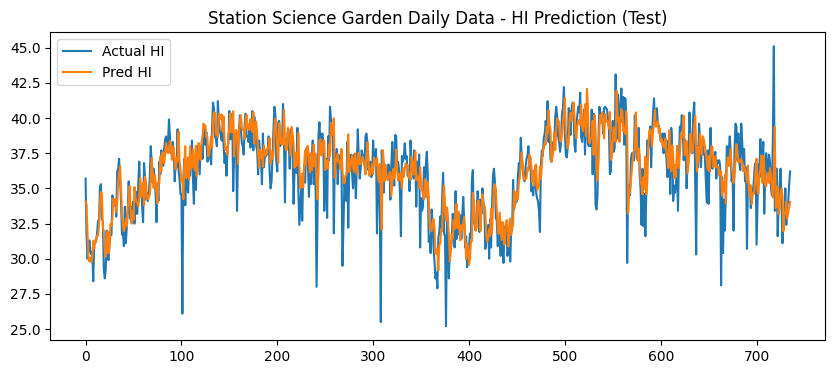

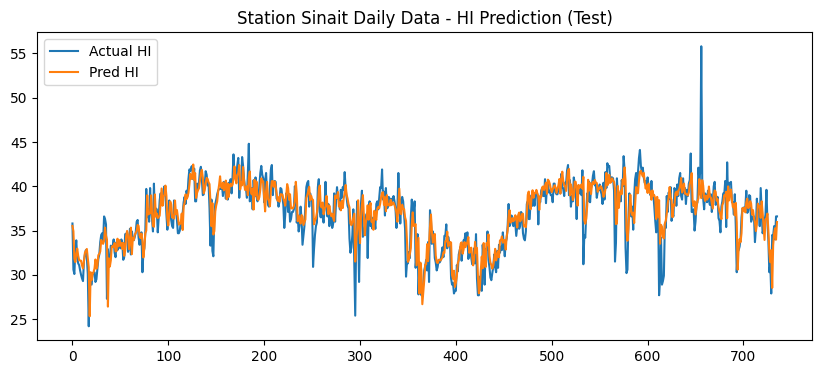

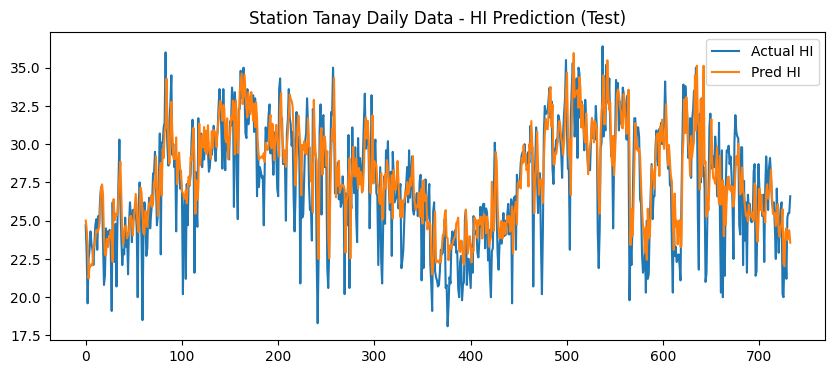

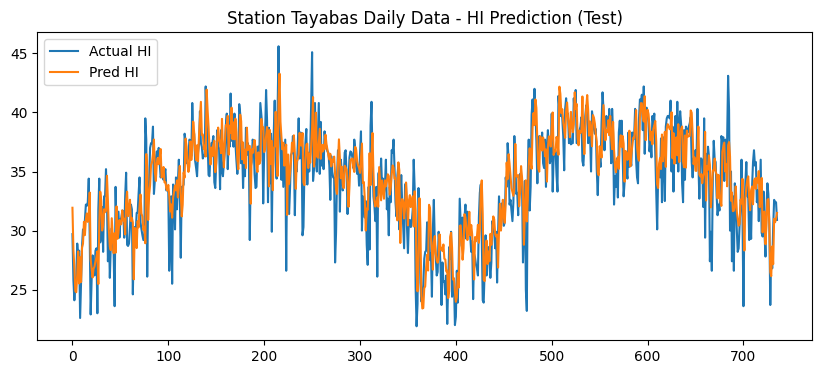

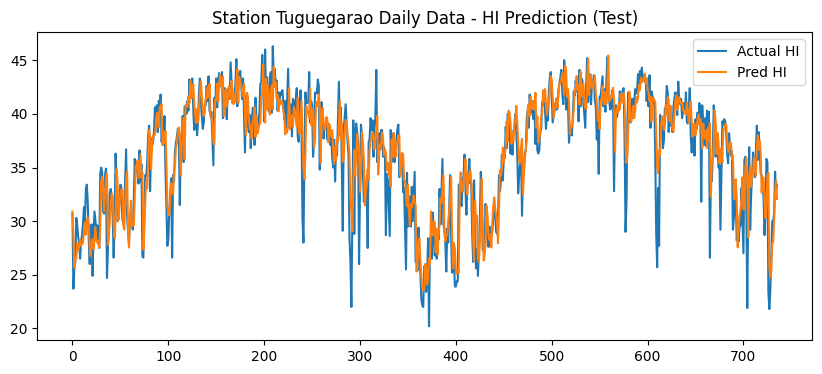

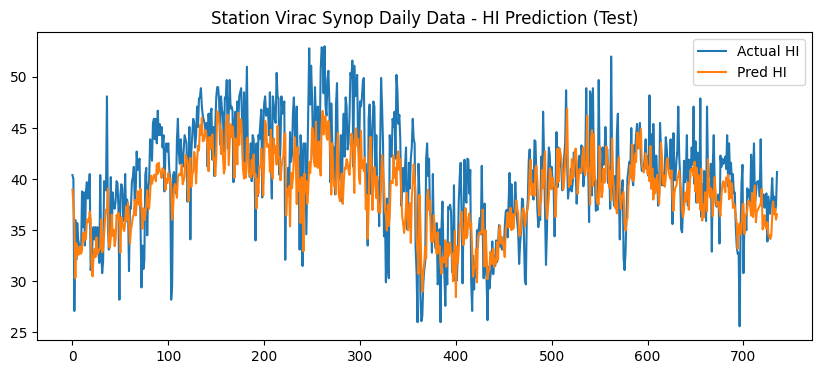

In [21]:
# Plot actual vs predicted per station (test set)
for st in stations_test.unique():
    idx = stations_test == st
    plt.figure(figsize=(10,4))
    plt.plot(y_test[idx].values[:,0], label="Actual HI")
    plt.plot(test_pred[idx][:,0], label="Pred HI")
    plt.title(f"Station {st} - HI Prediction (Test)")
    plt.legend()
    plt.show()
